In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "features.csv"

# Load the latest version
df1 = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "aslanahmedov/walmart-sales-forecast",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)



<ipython-input-94-bcf1b07f3c41>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df1 = kagglehub.load_dataset(


In [ ]:
# Set the path to the file you'd like to load
file_path = "stores.csv"

# Load the latest version
df2 = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "aslanahmedov/walmart-sales-forecast",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)


<ipython-input-95-92f671d8c215>:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df2 = kagglehub.load_dataset(


In [ ]:
# Set the path to the file you'd like to load
file_path = "train.csv"

# Load the latest version
df3 = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "aslanahmedov/walmart-sales-forecast",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print(df3.shape)

<ipython-input-96-48e1ed0aa2cf>:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df3 = kagglehub.load_dataset(


(421570, 5)


In [ ]:
import pandas as pd

result = pd.merge(df1, df2, on='Store', how='inner')

In [ ]:
final = pd.merge(result, df3, on=['Store', 'Date'], how='inner')

In [ ]:

missing_percentages = final.isnull().sum() * 100 / len(final)
missing_percentages


,0
Store,0.000000
Date,0.000000
Temperature,0.000000
Fuel_Price,0.000000
MarkDown1,64.257181
MarkDown2,73.611025
MarkDown3,67.480845
MarkDown4,67.984676
MarkDown5,64.079038
CPI,0.000000


In [ ]:
final.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3' , 'MarkDown4', 'MarkDown5'], inplace=True)

In [ ]:
final.drop(columns=['IsHoliday_y'], inplace=True)

In [ ]:
final.columns

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'IsHoliday_x', 'Type', 'Size', 'Dept', 'Weekly_Sales'],
      dtype='object')

In [ ]:
final.head(5)

,Store,ds,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_x,Type,Size,Dept,y
0,1,2010-02-05,42.31,2.572,211.096358,8.106,False,A,151315,1,24924.50
1,1,2010-02-05,42.31,2.572,211.096358,8.106,False,A,151315,2,50605.27
2,1,2010-02-05,42.31,2.572,211.096358,8.106,False,A,151315,3,13740.12
3,1,2010-02-05,42.31,2.572,211.096358,8.106,False,A,151315,4,39954.04
4,1,2010-02-05,42.31,2.572,211.096358,8.106,False,A,151315,5,32229.38


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize encoder
encoder = LabelEncoder()

# Fit and transform
final['Type'] = encoder.fit_transform(final['Type'])

final['IsHoliday_x'] = encoder.fit_transform(final['IsHoliday_x'])



In [ ]:
#Data Preprocessing

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

y=final['Date']

final.drop(columns=['Date'], inplace=True)

scaled_data = scaler.fit_transform(final)

scaled_df = pd.DataFrame(scaled_data, columns=final.columns, index=final.index)

scaled_df['Date'] = y

scaled_df['Date'] = pd.to_datetime(scaled_df['Date'])

# Extract numerical features
scaled_df['hour'] = scaled_df['Date'].dt.hour
scaled_df['day'] = scaled_df['Date'].dt.day
scaled_df['dayofweek'] = scaled_df['Date'].dt.dayofweek
scaled_df['month'] = scaled_df['Date'].dt.month

scaled_df.drop(columns=['Date'], inplace=True)

In [ ]:
tgt=scaled_df['Weekly_Sales']

scaled_df.drop(columns=['Weekly_Sales'], inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_df, tgt, test_size=0.2, random_state=42)


In [ ]:
X_train['tgt']=y_train

X_test['tgt']=y_test

In [ ]:
X_train.columns

Index(['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'IsHoliday_x', 'Type', 'Size', 'Dept', 'hour', 'day', 'dayofweek',
       'month', 'tgt'],
      dtype='object')

In [ ]:
X_test_e = X_test[X_test['IsHoliday_x'] == 1]

y_test_e = X_test_e['tgt']


## LSTM

In [ ]:
import numpy as np
def create_multivariate_sequences(df, target_col, window_size):
    X, y = [], []
    feature_cols = df.columns.drop(target_col)
    data = df[feature_cols].values
    target = df[target_col].values

    for i in range(len(df) - window_size):
        X.append(data[i:i+window_size])
        y.append(target[i+window_size])

    return np.array(X), np.array(y)

window_size = 10
X_tr, y_tr = create_multivariate_sequences(X_train, target_col='tgt', window_size=window_size)

# Reshape for LSTM: [samples, timesteps, features]
X_tr = X_tr.reshape((X_tr.shape[0],10, 13))



In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class FeatureAttention(Layer):
    def __init__(self, **kwargs):
        super(FeatureAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch_size, timesteps, features)
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),   # weight per feature
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[1], 1),    # bias per timestep
                                 initializer="zeros")
        super(FeatureAttention, self).build(input_shape)

    def call(self, inputs):
        # inputs: (batch_size, timesteps, features)
        e = tf.keras.backend.tanh(tf.keras.backend.dot(inputs, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=2)  # Softmax **over features** now (axis=2)
        output = inputs * a
        output = tf.keras.backend.sum(output, axis=2)  # Sum over features
        return output, a  # output: (batch_size, timesteps), a: (batch_size, timesteps, features)

    def compute_output_shape(self, input_shape):
        return [(input_shape[0], input_shape[1]), (input_shape[0], input_shape[1], input_shape[2])]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

inputs = Input(shape=(window_size, 13))  # 10 timesteps, 13 features
lstm_out = LSTM(64, return_sequences=True)(inputs)
feature_attention_out, feature_attention_scores = FeatureAttention()(lstm_out)
dense_out = Dense(1)(feature_attention_out)  # Predict 1 value per timestep

model = Model(inputs=inputs, outputs=dense_out)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 10, 13)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 10, 64)         │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_attention_2             │ [(None, 10), (None,    │            74 │
│ (FeatureAttention)              │ 10, 64)]               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,053 (78.33 KB)

 Trainable params: 20,053 (78.33 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_tr, y_tr,
                    epochs=1,
                    batch_size=256,
                    validation_split=0.1)

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - loss: 0.1615 - val_loss: 0.0019


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


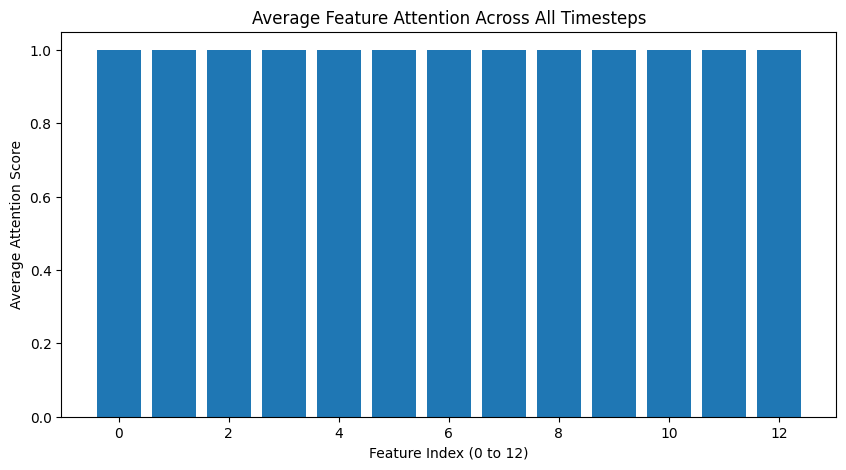

In [ ]:
# Build extractor model
feature_attention_extractor = Model(inputs=inputs, outputs=feature_attention_scores)

window_size = 10
X_ts, y_ts = create_multivariate_sequences(X_test, target_col='tgt', window_size=window_size)

# Reshape for LSTM: [samples, timesteps, features]
X_ts = X_ts.reshape((X_ts.shape[0],10, 13))
sample_input = X_ts  # One sample
# 1. Predict attention scores for all samples
attention_scores_all = feature_attention_extractor.predict(X_ts)  # shape (num_samples, 10, 13)

# 2. First, average over timesteps (axis=1)
attention_mean_over_timesteps = attention_scores_all.mean(axis=1)  # shape (num_samples, 13)

# 3. Then, average over all samples (axis=0)
attention_mean_over_all = attention_mean_over_timesteps.mean(axis=0)  # shape (13,)
# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.bar(range(13), attention_mean_over_all)
plt.title('Average Feature Attention Across All Timesteps')
plt.xlabel('Feature Index (0 to 12)')
plt.ylabel('Average Attention Score')
plt.show()

In [ ]:
X_tse, y_tse = create_multivariate_sequences(X_test_e, target_col='tgt', window_size=window_size)

# Reshape for LSTM: [samples, timesteps, features]
X_tse = X_tse.reshape((X_tse.shape[0],10, 13))

In [ ]:
y_pred_e=model.predict(X_tse)

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mape = mean_absolute_percentage_error(y_tse, y_pred_e)
print(f"MAPE: {mape:.2f}%")

MAPE: 251.16%
